# [개념 필사] - 딥러닝 파이토치

## CHAPTER 05 <합성곱 신경망 I>

## **5.2 합성곱 신경망 맛보기**

> 💠fashion_mnist 데이터셋: 의류와 관련된 작은 이미지들 / 레이블값 0~9

(1) 라이브러리 호출, 데이터셋 내려받기  

* GPU 사용 지정: 다수의 GPU 사용 시, nn.DataParallel 이용

* 데이터셋 내려받기
```
torchvision.datasets('내려받을 위치 지정', download=True, transform=이미지를 텐서로 변경)
```
* 데이터로더 전달
```
torch.utils.data.DataLoader(데이터셋 지정, batch_size=데이터를 불러올때 묶는 단위 지정) - 원하는 크기의 배치 단위로 데이터를 불러오거나 순서 섞기 가능
```
(2) 분류에 사용될 클래스 정의


---



✅ 합성곱 신경망 VS. 심층 신경망 (비교 해보기)

(3) 심층 신경망 생성, 학습

* 모델 생성 ▶ 손실함수, 학습률, 옵티마이저 정의 ▶ 모델 학습
* 최종 정확도: 86%

(4) 합성곱 신경망 생성, 학습

* 합성곱 네트워크 생성 ▶ 손실함수, 학습률, 옵티마이저 정의 ▶ 모델 학습
* 최종 정확도: 89%

✅ 이미지 데이터가 많아질수록 CNN 좋음

# [코드 필사]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.5MB/s]


In [4]:
# 데이터를 데이터로더에 전달
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)



---



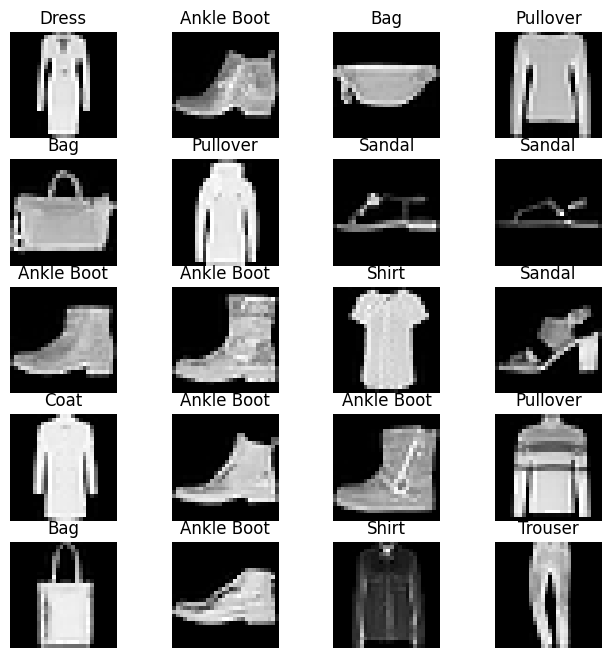

In [5]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker',
              8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8));
columns = 4;
rows = 5;
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:];
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()



---



In [7]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__() # nn.Module 클래스를 상속받는다는 의미
    self.fc1 = nn.Linear(in_features=784, out_features=256) # 단순 선형 회귀, 입력크기 874, 출력크기 256
    self.drop = nn.Dropout(0.25) # 0.25만큼의 비율로 텐서값 -> 0, 나머지 -> (기존값)*(1/(1-p))
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)
  def forward(self, input_data): # 학습 데이터를 입력받아 순전파 학습을 진행시키는 함수
    out = input_data.view(-1, 784) # reshape(?,784)라는 의미
    out = F.relu(self.fc1(out)) # 활성화 함수 정의
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

* 활성화 함수 지정 방법



1.   F.xx(): forward() 함수에서 정의 / 입력, 가중치 자체를 직접 넣어줌.
```
outputs = F.conv2d(inputs, weight , bias, padding=1)
```
2.   nn.xx(): __init__ 함수에서 정의 /
```
conv = nn .Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
```

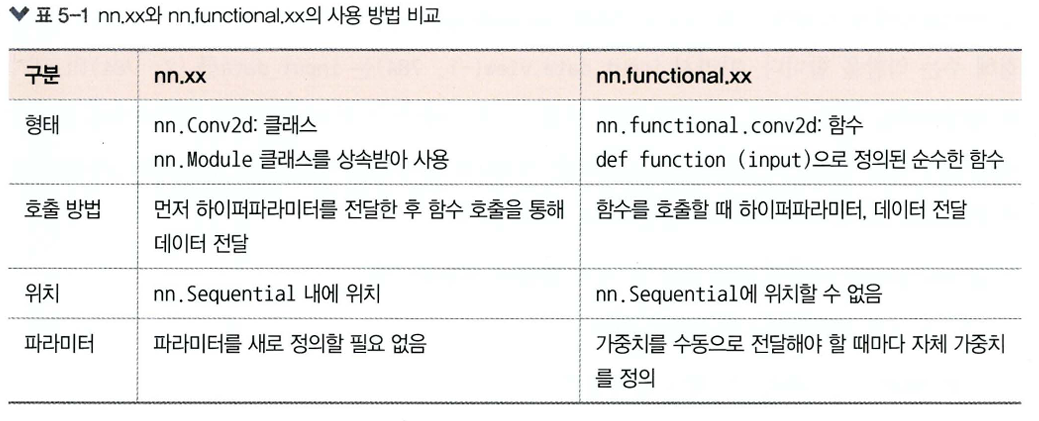



In [9]:
# 학습을 위한 파라미터 정의
learning_rate = 0.001
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # Adam 경사 하강법 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
num_epochs = 5
count = 0
loss_list = [] # 비어있는 배열 생성
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader: # 레코드를 하나씩 호출
    images, labels = images.to(device), labels.to(device) # 모델과 데이터가 동일한 장치에 있어야 함

    train = Variable(images.view(100, 1, 28, 28)) # autograd: Variable을 사용해 순전파에서 미분값 계산 후 저장, 이후 역전파에서 사용
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total # 정확도 계산
      loss_list.append(loss.data) # append()를 이용하여 비어있는 배열에 데이터 하나씩 추가
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500):
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5958877205848694, Accuracy: 83.40999603271484%
Iteration: 1000, Loss: 0.48016220331192017, Accuracy: 84.0%
Iteration: 1500, Loss: 0.361616313457489, Accuracy: 84.66999816894531%
Iteration: 2000, Loss: 0.38651204109191895, Accuracy: 85.3699951171875%
Iteration: 2500, Loss: 0.2591014504432678, Accuracy: 86.3499984741211%
Iteration: 3000, Loss: 0.3147573173046112, Accuracy: 86.72999572753906%




---



In [12]:
# CMM 네트워크 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential( # 순전파를 layer 형태로 가독성 있게 작성 가능
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 합성곱층 정의
        nn.BatchNorm2d(32), # 각 배치 단위 별로 데이터 분포가 다를 때 정규화
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # 이미지 크기 축소, 최대 풀링 수행
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1) # 완전연결층으로 전달하기 위해 1차원으로 변경. out.size(0)=100
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

* nn.Sequential : 계층을 차례로 쌓을 수 있도록 수식과 활성화 함수를 연결. 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋음

* nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
```
in_channels : 입력채널 수 (1 또는 3)
out_channels : 출력 채널 수
kernel_size : 커널(필터) 크기. 3은 3x3 크기의 커널 의미. (3,5) 처럼 직사각형 지정 가능
padding : 패딩 크기. 패딩 값이 클수록 출력 크기 증가
```

* nn.MaxPool2d(kernel_size=2, stride=2): 풀링 계층에서의 연산
```
kernel_size : m*n 행렬로 구성된 가중치
stride : 값이 클수록 출력 크기 감소
```

* Conv2d의 출력 크기 = (W-F+2P)/S+1
* MaxPool2d의 출력 크기 = IF (입력필터 크기)/F


In [13]:
# 파라미터 정의
learning_rate = 0.001
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # Adam 경사 하강법 사용
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
num_epochs = 5
count = 0
loss_list = [] # 비어있는 배열 생성
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader: # 레코드를 하나씩 호출
    images, labels = images.to(device), labels.to(device) # 모델과 데이터가 동일한 장치에 있어야 함

    train = Variable(images.view(100, 1, 28, 28)) # autograd: Variable을 사용해 순전파에서 미분값 계산 후 저장, 이후 역전파에서 사용
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total # 정확도 계산
      loss_list.append(loss.data) # append()를 이용하여 비어있는 배열에 데이터 하나씩 추가
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500):
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.46097031235694885, Accuracy: 87.05999755859375%
Iteration: 1000, Loss: 0.3730720579624176, Accuracy: 87.81999969482422%
Iteration: 1500, Loss: 0.33100268244743347, Accuracy: 87.79000091552734%
Iteration: 2000, Loss: 0.2719687223434448, Accuracy: 89.29999542236328%
Iteration: 2500, Loss: 0.13093943893909454, Accuracy: 89.58999633789062%
Iteration: 3000, Loss: 0.18834766745567322, Accuracy: 89.61000061035156%
